```markdown
___Ejercicio 16__

Este es un conjunto de datos públicos de comercio electrónico brasileño de pedidos realizados en Olist Store. El conjunto de datos tiene información de **100 000 pedidos** de **2016 a 2018** realizados en varios mercados de Brasil.

Sus características permiten ver un pedido desde múltiples dimensiones:
- Estado del pedido
- Precio
- Pago
- Rendimiento del flete
- Ubicación del cliente
- Atributos del producto
- Reseñas escritas por los clientes

```

In [ ]:
import kagglehub


path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")  # Descargar dataset de Kaggle

print("Path to dataset files:", path)

C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Manuel\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


In [ ]:
import os
import pandas as pd

files = os.listdir(path) # Obtener la lista de archivos en el directorio

csv_files = [f for f in files if f.endswith('.csv')] # Filtrar solo los archivos CSV

dataframes = {}

for file in csv_files:  # Leer cada archivo CSV y almacenarlo en el diccionario
    file_path = os.path.join(path, file)
    df_name = os.path.splitext(file)[0]  # Nombre del dataframe sin la extensión .csv
    dataframes[df_name] = pd.read_csv(file_path)


print(dataframes.keys()) # Mostrar los nombres de los dataframes

dict_keys(['olist_customers_dataset', 'olist_geolocation_dataset', 'olist_orders_dataset', 'olist_order_items_dataset', 'olist_order_payments_dataset', 'olist_order_reviews_dataset', 'olist_products_dataset', 'olist_sellers_dataset', 'product_category_name_translation'])


In [ ]:
print(dataframes['olist_customers_dataset']) # Mostrar el contenido del dataframe 'olist_customers_dataset'

                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0  

In [ ]:

from google.oauth2 import service_account 
bq_cred = service_account.Credentials.from_service_account_file(r'D:\BOOTCAMP\DataBootcamp\tactical-hydra-440201-p5-61a36569c7db.json')
bq_cred # Generamos conexion a BQ mediante credenciales


In [ ]:
import pandas_gbq
from google.cloud import bigquery
from google.oauth2 import service_account

project_id = 'tactical-hydra-440201-p5' #se subira a este proyecto creado en la clase de BQ
dataset_id = f'{project_id}.olistbr_brazilian_ecommerce'  # nombramos el dataset como 'olistbr_brazilian_ecommerce' 

client = bigquery.Client(project=project_id, credentials=bq_cred)# Crear un cliente de BigQuery

dataset = bigquery.Dataset(dataset_id)# Crear el  Dataset
dataset.location = 'US' 

dataset = client.create_dataset(dataset, exists_ok=True) # Crear el dataset si no existe
print(f"Dataset {dataset_id} creado o ya existente.")

Dataset tactical-hydra-440201-p5.olistbr_brazilian_ecommerce creado o ya existente.


In [ ]:
for table_id, df in dataframes.items(): # Iterar sobre los DataFrames y cargarlos en BigQuery
     destination_table = f'olistbr_brazilian_ecommerce.{table_id}'
    
pandas_gbq.to_gbq(
        df,
        destination_table=destination_table,
        project_id=project_id,
        if_exists='replace',
        credentials=bq_cred
    )  # Cargar el DataFrame en BigQuery mediante esquema de reemplazo
print(f"Tabla {destination_table} cargada exitosamente.")

100%|██████████| 1/1 [00:00<?, ?it/s]

Tabla olistbr_brazilian_ecommerce.product_category_name_translation cargada exitosamente.


In [ ]:
# consulta para optener el total de ventas mensuales 
query = """
SELECT
    DATE_TRUNC(PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', o.order_purchase_timestamp), MONTH) AS month,
    SUM(oi.price) AS total_sales
FROM
    `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
JOIN
    `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_orders_dataset` AS o
ON
    oi.order_id = o.order_id
GROUP BY
    month
ORDER BY
    month
"""
# Ejecutamos una consulta donde agrupasmos las ventas por mes mediante la funcion date_trunc sobre la 
# columna order_purchase_timestamp de la tabla olist_order_items_dataset y suma los precios de los productos 
# tomando el valor de la columna price de la tabla olist_order_items_dataset, se asigna un alias a la tabla de items 
# y una alias a la tabla de orders, para luego hacer un join entre las dos tablas mediante la columna order_id, 
# finalmente se agrupan mediante la columna month y se ordenan por la columna month.
monthly_sales = client.query(query).to_dataframe()
print(monthly_sales)

C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                       month  total_sales
0  2016-09-01 00:00:00+00:00       267.36
1  2016-10-01 00:00:00+00:00     49507.66
2  2016-12-01 00:00:00+00:00        10.90
3  2017-01-01 00:00:00+00:00    120312.87
4  2017-02-01 00:00:00+00:00    247303.02
5  2017-03-01 00:00:00+00:00    374344.30
6  2017-04-01 00:00:00+00:00    359927.23
7  2017-05-01 00:00:00+00:00    506071.14
8  2017-06-01 00:00:00+00:00    433038.60
9  2017-07-01 00:00:00+00:00    498031.48
10 2017-08-01 00:00:00+00:00    573971.68
11 2017-09-01 00:00:00+00:00    624401.69
12 2017-10-01 00:00:00+00:00    664219.43
13 2017-11-01 00:00:00+00:00   1010271.37
14 2017-12-01 00:00:00+00:00    743914.17
15 2018-01-01 00:00:00+00:00    950030.36
16 2018-02-01 00:00:00+00:00    844178.71
17 2018-03-01 00:00:00+00:00    983213.44
18 2018-04-01 00:00:00+00:00    996647.75
19 2018-05-01 00:00:00+00:00    996517.68
20 2018-06-01 00:00:00+00:00    865124.31
21 2018-07-01 00:00:00+00:00    895507.22
22 2018-08-01 00:00:00+00:00    85

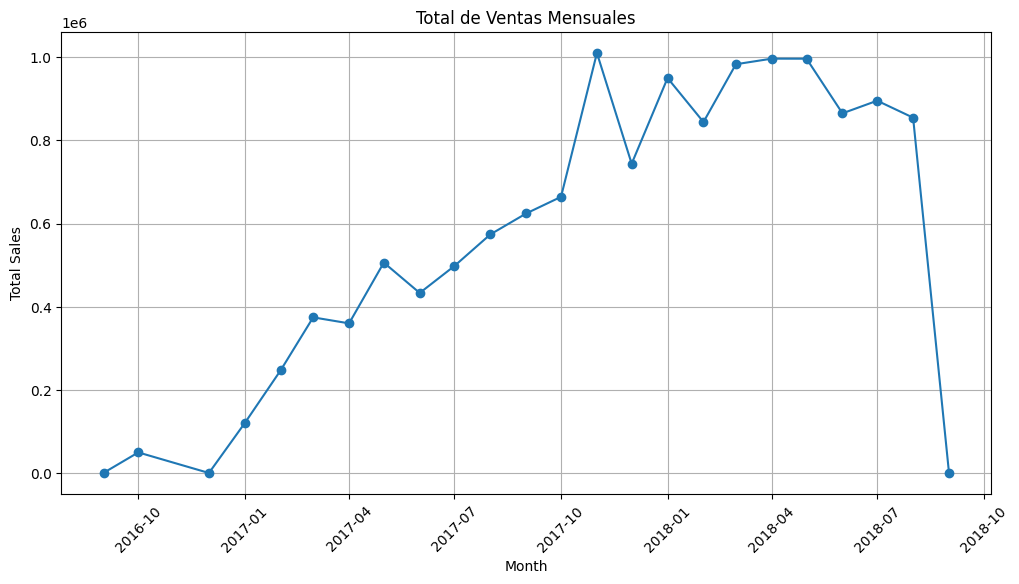

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(monthly_sales['month'], monthly_sales['total_sales'], marker='o')

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total de Ventas Mensuales')

plt.xticks(rotation=45)

plt.grid(True)
plt.show()

In [ ]:
# consulta para obtener las 10 categorías de productos más populares
query_top_categories = """
SELECT
    product_category_name,
    COUNT(*) AS count
FROM
    `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_products_dataset`
GROUP BY
    product_category_name
ORDER BY
    count DESC
LIMIT 10
"""
# Ejecutamos una consulta donde se selecciona la columna product_category_name y se cuenta el número de veces que
# se repite cada categoría mediante la función count, se agrupan mediante la columna product_category_name 
# y se ordenan de forma descendente, finalmente se limita a 10 el número de resultados.
top_categories_df = client.query(query_top_categories).to_dataframe()


C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

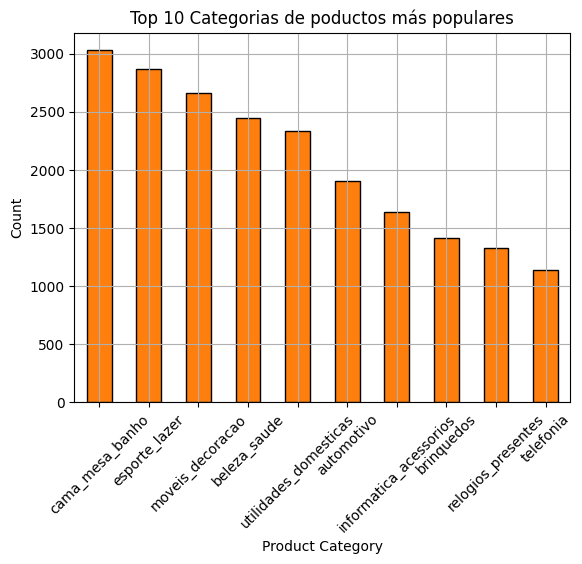

In [35]:

plt.figure(figsize=(12, 6))
colors = plt.cm.tab10.colors  
top_categories_df.plot(kind='bar', x='product_category_name', y='count', color=colors[1], edgecolor='black', legend=False)

plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Top 10 Categorias de poductos más populares')

plt.xticks(rotation=45)

plt.grid(True)
plt.show()

In [ ]:
# consulta para obtener las ventas totales por tipo de pago

query_sales_by_payment = """
SELECT
    payment_type,
    SUM(price) AS total_sales
FROM
    `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_order_payments_dataset` AS op
JOIN
    `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
ON
    op.order_id = oi.order_id
GROUP BY
    payment_type
ORDER BY
    total_sales DESC
"""
# Ejecutamos una consulta donde se selecciona la columna payment_type de la tabla olist_order_payments_dataset 
# y la columna price de la tabla olist_order_items_dataset. Se realiza un JOIN entre las dos tablas utilizando
# la columna order_id. Se agrupa por payment_type y se calcula la suma de los precios de los productos vendidos. 
# Finalmente se ordena el resultado de forma descendente por total_sales.

sales_by_payment_df = client.query(query_sales_by_payment).to_dataframe()


C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

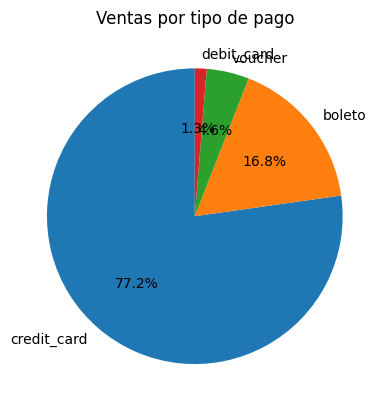

In [34]:

# Graficar la Query de ventas por tipo de pago
plt.figure(figsize=(8, 8))
sales_by_payment_df.set_index('payment_type').plot(kind='pie', y='total_sales', autopct='%1.1f%%', startangle=90, colors=colors, legend=False)

plt.ylabel('')
plt.title('Ventas por tipo de pago')
plt.show()

In [ ]:
#generamos una consulta de las tendencias en categorias de productos mas vendidas en el 2017

query_top_products_trends = """
WITH top_products AS (
    SELECT
        p.product_category_name,
        COUNT(*) AS count
    FROM
        `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
    JOIN
        `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_products_dataset` AS p
    ON
        oi.product_id = p.product_id
    GROUP BY
        p.product_category_name
    ORDER BY
        count DESC
    LIMIT 10
),
monthly_sales AS (
    SELECT
        DATE_TRUNC(PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', o.order_purchase_timestamp), MONTH) AS month,
        p.product_category_name,
        SUM(oi.price) AS total_sales
    FROM
        `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
    JOIN
        `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_orders_dataset` AS o
    ON
        oi.order_id = o.order_id
    JOIN
        `tactical-hydra-440201-p5.olistbr_brazilian_ecommerce.olist_products_dataset` AS p
    ON
        oi.product_id = p.product_id
    WHERE
        EXTRACT(YEAR FROM PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', o.order_purchase_timestamp)) = 2017
    GROUP BY
        month, p.product_category_name
)
SELECT
    ms.month,
    ms.product_category_name,
    ms.total_sales
FROM
    monthly_sales AS ms
JOIN
    top_products AS tp
ON
    ms.product_category_name = tp.product_category_name
ORDER BY
    ms.month, ms.total_sales DESC
"""
# se crea la subconsulta top_products que selecciona la columna product_category_name 
# de la tabla olist_products_dataset y cuenta el número de productos vendidos, y los agrupa por product_category_name 
# y se ordena de forma descendente por count. Se seleccionan las 10 categorías de productos más vendidas. Luego se hace 
# una subconsulta monthly_sales que selecciona la columna order_purchase_timestamp de la tabla olist_orders_dataset
# y product_category_name de la tabla olist_products_dataset. Se agrupa por mes y product_category_name y se calcula la suma y 
# total_sales de la suma de los precios de la tabla olist_order_items_dataset.
# Finalmente se hace la consulta principal donde se seleccionan las columnas month, product_category_name y total_sales 
# de la subconsulta monthly_sales y se hace un JOIN con la subconsulta top_products. 
# Se ordena por mes y total_sales de forma descendente.


top_products_trends_df = client.query(query_top_products_trends).to_dataframe()
print(top_products_trends_df)

C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                        month   product_category_name  total_sales
0   2017-01-01 00:00:00+00:00        moveis_decoracao     13521.31
1   2017-01-01 00:00:00+00:00            beleza_saude     12561.32
2   2017-01-01 00:00:00+00:00           esporte_lazer      9717.62
3   2017-01-01 00:00:00+00:00      ferramentas_jardim      8152.75
4   2017-01-01 00:00:00+00:00      relogios_presentes      8086.52
..                        ...                     ...          ...
115 2017-12-01 00:00:00+00:00  informatica_acessorios     37880.65
116 2017-12-01 00:00:00+00:00        moveis_decoracao     32011.75
117 2017-12-01 00:00:00+00:00      ferramentas_jardim     27689.69
118 2017-12-01 00:00:00+00:00   utilidades_domesticas     25921.95
119 2017-12-01 00:00:00+00:00               telefonia     13611.01

[120 rows x 3 columns]


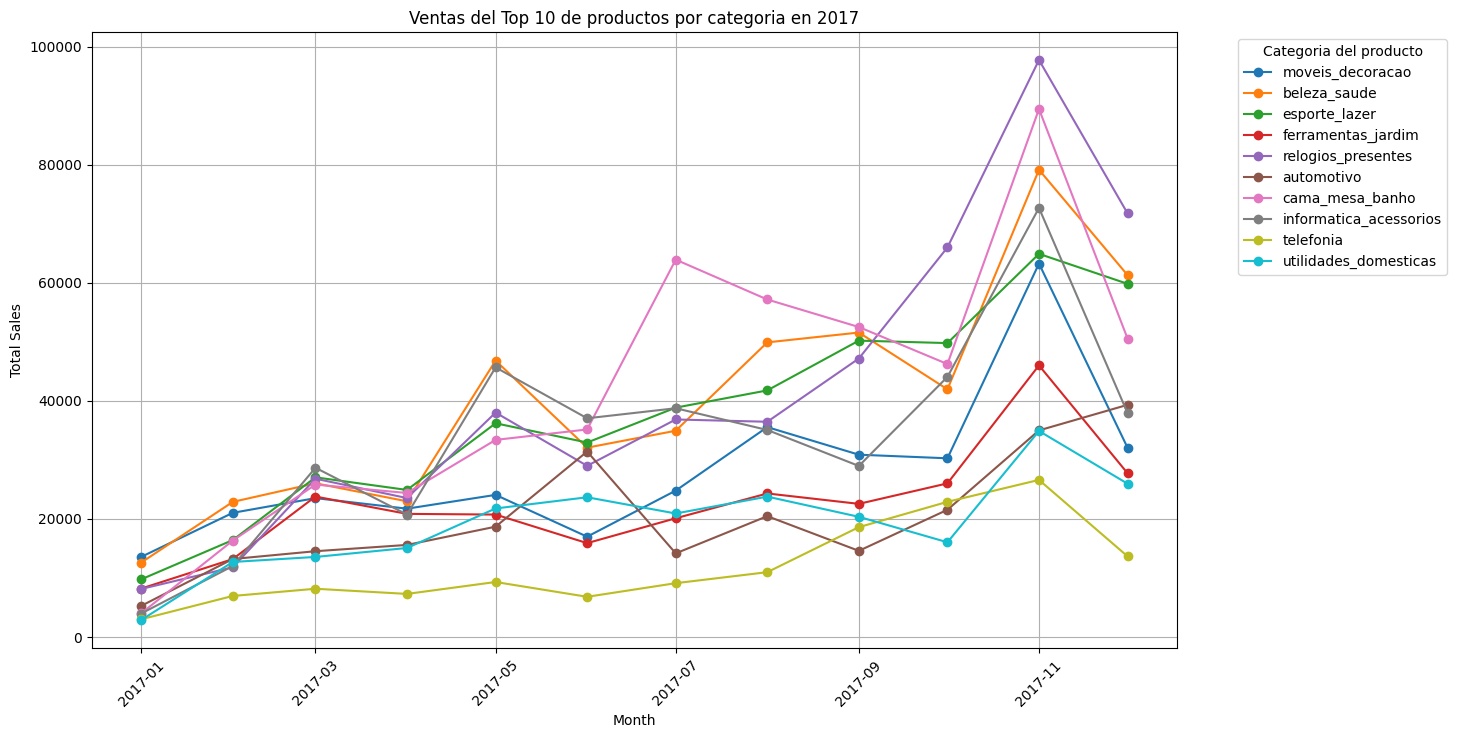

In [37]:

plt.figure(figsize=(14, 8))

# Graficar cada categoría de producto
for category in top_products_trends_df['product_category_name'].unique():
    category_data = top_products_trends_df[top_products_trends_df['product_category_name'] == category]
    plt.plot(category_data['month'], category_data['total_sales'], marker='o', label=category)

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Ventas del Top 10 de productos por categoria en 2017')
plt.legend(title='Categoria del producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()